<a href="https://colab.research.google.com/github/MonteiroAlvesMatheus/TCC/blob/main/Treinamento_Valida%C3%A7%C3%A3o_Cruzada_CNN_SIMPLES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# instalando o a biblioteca pydicom
!pip install pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.6 MB/s eta 0:00:00


In [ ]:
#importando as bibliotecas
import pandas as pd
import os
import numpy as np
import random
import pydicom as dicom
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import subprocess
from PIL import Image
from google.colab.patches import cv2_imshow
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
from tensorflow.keras.metrics import CategoricalAccuracy, AUC, Precision, Recall
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, precision_score, recall_score

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#descompactando o banco de dados
!unzip "/content/drive/MyDrive/TCC/ds-parte1.zip"
!unzip "/content/drive/MyDrive/TCC/ds-parte2.zip"

A saída de streaming foi truncada nas últimas 5000 linhas.
   creating: SCD0004201/3.276_2YMAJdAczcjAfXpHFLC6Zj453OlBWiLWSRfwuO3ZLEpPqrg3VQX9CQFKPIdx8Vg6I_+x_-x_256_256_-38/
  inflating: SCD0004201/3.276_2YMAJdAczcjAfXpHFLC6Zj453OlBWiLWSRfwuO3ZLEpPqrg3VQX9CQFKPIdx8Vg6I_+x_-x_256_256_-38/CAP_SCD0004201_MR__hrt_raw_20120813124049187_3.dcm  
  inflating: SCD0004201/3.276_2YMAJdAczcjAfXpHFLC6Zj453OlBWiLWSRfwuO3ZLEpPqrg3VQX9CQFKPIdx8Vg6I_+x_-x_256_256_-38/SCD0004201.log  
   creating: SCD0004201/3.276_2YMAJdAczcjAfXpHFLC6Zj453OlBWiLWSRfwuO3ZLEpPqrg3VQX9CQFKPIdx8Vg6I_+x_-x_256_256_-44/
  inflating: SCD0004201/3.276_2YMAJdAczcjAfXpHFLC6Zj453OlBWiLWSRfwuO3ZLEpPqrg3VQX9CQFKPIdx8Vg6I_+x_-x_256_256_-44/CAP_SCD0004201_MR__hrt_raw_20120813124049210_4.dcm  
  inflating: SCD0004201/3.276_2YMAJdAczcjAfXpHFLC6Zj453OlBWiLWSRfwuO3ZLEpPqrg3VQX9CQFKPIdx8Vg6I_+x_-x_256_256_-44/SCD0004201.log  
   creating: SCD0004201/3.276_2YMAJdAczcjAfXpHFLC6Zj453OlBWiLWSRfwuO3ZLEpPqrg3VQX9CQFKPIdx8Vg6I_+x_-x_256_256_-51/


In [ ]:
#Dataframe Treino
df_treino_fold1 = pd.read_csv('/content/drive/MyDrive/TCC/Validação Cruzada/treino_fold1.csv')
df_treino_fold2 = pd.read_csv('/content/drive/MyDrive/TCC/Validação Cruzada/treino_fold2.csv')
df_treino_fold3 = pd.read_csv('/content/drive/MyDrive/TCC/Validação Cruzada/treino_fold3.csv')
df_treino_fold4 = pd.read_csv('/content/drive/MyDrive/TCC/Validação Cruzada/treino_fold4.csv')

In [ ]:
#Dataframe Validação Cruzada
df_fold1 = pd.read_csv('/content/drive/MyDrive/TCC/Validação Cruzada/fold1.csv')
df_fold2 = pd.read_csv('/content/drive/MyDrive/TCC/Validação Cruzada/fold2.csv')
df_fold3 = pd.read_csv('/content/drive/MyDrive/TCC/Validação Cruzada/fold3.csv')
df_fold4 = pd.read_csv('/content/drive/MyDrive/TCC/Validação Cruzada/fold4.csv')

In [ ]:
df_teste = pd.read_csv('/content/drive/MyDrive/TCC/df_teste.csv')

In [ ]:
def batch_generator(df, batch_size, _mode, label_set, tam_img):
      while True:
          # Depending on mode select DataFrame with paths
          if _mode == 'train':
              ids = random.sample(range(df.shape[0]), df.shape[0])
          elif _mode == 'val':
              ids = list(range(df.shape[0]))
          else:
              raise ValueError('The mode should be either train or val.')

          # Create batches (for training data the batches are randomly permuted)
          for start in range(0, len(ids), batch_size):
              X_batch = []
              y_batch = []
              end = min(start + batch_size, len(ids))
              i_batch = ids[start:end]
              for i in i_batch:
                  end_imgs = df['Caminho das imagens'].iloc[i]
                  ds=dicom.dcmread(end_imgs)
                  dcm_sample=ds.pixel_array
                  X_batch.append(np.float32(dcm_sample/np.max(dcm_sample)))
                  y_batch.append(label_set[df['Classe'].iloc[i]])
              X_batch = np.array(X_batch)
              X_batch = np.reshape(X_batch, (X_batch.shape[0],tam_img, tam_img, 1)) #corrigindo a dimensão da imagem pra 256x256x1

              y_batch = np_utils.to_categorical(y_batch, num_classes = len(label_set))
              yield (X_batch, y_batch)

In [ ]:
rotulo = {'Infarto': 0, 'Insuficiencia': 1, 'Hipertrofia': 2, 'Normal': 3}

In [ ]:
#Parametros

batch_size = 32
tam_img = 256

In [ ]:
data_teste=[]
target_teste=[]

for n in range(len(df_teste)):
  end_imgs = df_teste['Caminho das imagens'].iloc[n]
  ds=dicom.dcmread(end_imgs)
  dcm_sample=ds.pixel_array
  data_teste.append(np.float32(dcm_sample/np.max(dcm_sample))) #Normalizado entre 0 e 1
  target_teste.append(rotulo[df_teste['Classe'].iloc[n]]) #rotulando as imagens de acordo com as classes

In [ ]:
data_teste = np.array(data_teste)
data_teste = np.reshape(data_teste, (data_teste.shape[0],tam_img,tam_img,1)) #corrigindo a dimensão da imagem pra 256x256x1
target_teste = np.array(target_teste)
target_teste= np_utils.to_categorical(target_teste)

In [ ]:
# define modelo
model = keras.Sequential([
    keras.layers.Conv2D(8, (3, 3), strides = (1,1),padding='same', input_shape=(256,256,1)),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'),
    keras.layers.Conv2D(16, (3, 3), strides = (1,1), padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'),
    keras.layers.Flatten(),
    keras.layers.Dense(4, activation='softmax')
])

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.01)

In [ ]:
metricasEscolhidas = [CategoricalAccuracy(name='acc'),
                      AUC(name='auc'),
                      Precision(name='precision'),
                      Recall(name='recall')]

In [ ]:
# compila do modelo
model.compile(optimizer= opt,
              loss='categorical_crossentropy',
              metrics=metricasEscolhidas)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 8)       80        
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 8)      32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256, 256, 8)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 16)      1168      
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 16)     6

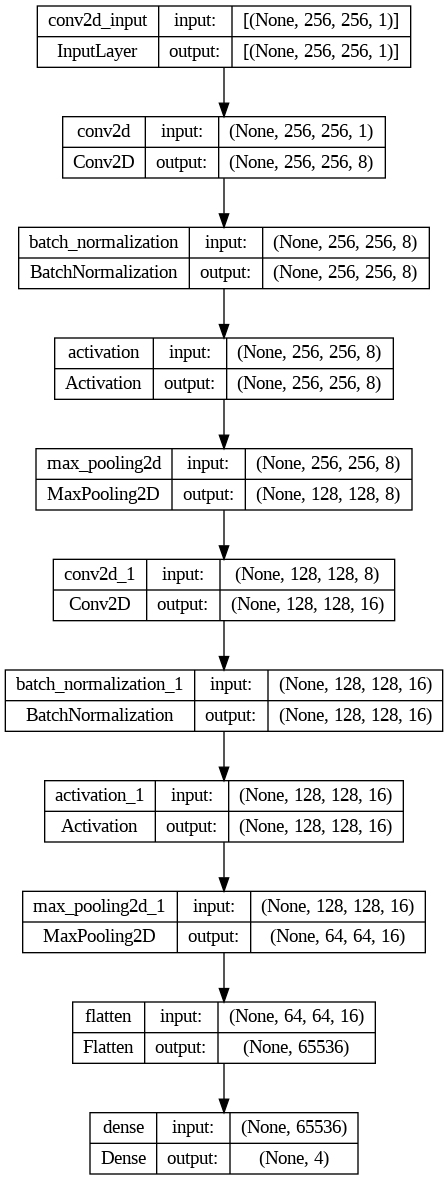

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
checkpoint = ModelCheckpoint('model-{epoch:03d}.model ', monitor = 'val_loss',verbose=1,save_best_only=True,mode='auto',save_weights_only=True)
es = EarlyStopping(monitor='val_loss', verbose=1, patience=25)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=20, min_lr=1e-10)
callbacks_list = [checkpoint,es,reduce_lr]

In [ ]:
# N=4
# for ival in range(N):
#     df_val = df_validacao[ival]
#     df_train = df_treino[ival]
#     history = model.fit(batch_generator(df_train, batch_size, _mode='train', label_set=rotulo, tam_img=tam_img),
#                         steps_per_epoch=int(np.ceil(len(df_train)/batch_size)),
#                         epochs=100, verbose=1,
#                         callbacks=callbacks_list,
#                         validation_data=batch_generator(df_val, batch_size, _mode='val', label_set=rotulo, tam_img=tam_img),
#                         validation_steps=int(np.ceil(len(df_val)/batch_size))
#                       )

In [ ]:
    history = model.fit(batch_generator(df_treino_fold1, batch_size, _mode='train', label_set=rotulo, tam_img=tam_img),
                        steps_per_epoch=int(np.ceil(len(df_treino_fold1)/batch_size)),
                        epochs=100, verbose=1,
                        callbacks=callbacks_list,
                        validation_data=batch_generator(df_fold1, batch_size, _mode='val', label_set=rotulo, tam_img=tam_img),
                        validation_steps=int(np.ceil(len(df_fold1)/batch_size))
                      )

Epoch 1/100
366/366 [==============================] - ETA: 0s - loss: 5.0942 - acc: 0.9022 - auc: 0.9479 - precision: 0.9031 - recall: 0.9018
Epoch 1: val_loss improved from inf to 8.92570, saving model to model-001.model 
366/366 [==============================] - 68s 149ms/step - loss: 5.0942 - acc: 0.9022 - auc: 0.9479 - precision: 0.9031 - recall: 0.9018 - val_loss: 8.9257 - val_acc: 0.4558 - val_auc: 0.6685 - val_precision: 0.4568 - val_recall: 0.4553 - lr: 0.0100
Epoch 2/100
365/366 [============================>.] - ETA: 0s - loss: 0.1092 - acc: 0.9832 - auc: 0.9959 - precision: 0.9835 - recall: 0.9832
Epoch 2: val_loss improved from 8.92570 to 4.86988, saving model to model-002.model 
366/366 [==============================] - 39s 106ms/step - loss: 0.1092 - acc: 0.9832 - auc: 0.9959 - precision: 0.9835 - recall: 0.9832 - val_loss: 4.8699 - val_acc: 0.5084 - val_auc: 0.7111 - val_precision: 0.5086 - val_recall: 0.5075 - lr: 0.0100
Epoch 3/100
365/366 [=========================

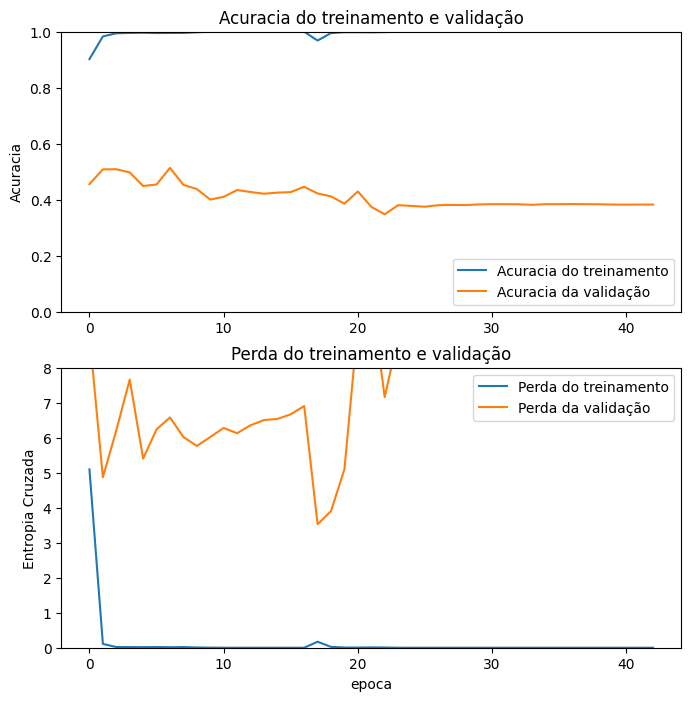

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Acuracia do treinamento')
plt.plot(val_acc, label='Acuracia da validação')
plt.legend(loc='lower right')
plt.ylabel('Acuracia')
plt.ylim([0,1])
plt.title('Acuracia do treinamento e validação')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Perda do treinamento')
plt.plot(val_loss, label='Perda da validação')
plt.legend(loc='upper right')
plt.ylabel('Entropia Cruzada')
plt.ylim([0,8])
plt.title('Perda do treinamento e validação')
plt.xlabel('epoca')
plt.show()

In [ ]:
    history = model.fit(batch_generator(df_treino_fold2, batch_size, _mode='train', label_set=rotulo, tam_img=tam_img),
                        steps_per_epoch=int(np.ceil(len(df_treino_fold2)/batch_size)),
                        epochs=100, verbose=1,
                        callbacks=callbacks_list,
                        validation_data=batch_generator(df_fold2, batch_size, _mode='val', label_set=rotulo, tam_img=tam_img),
                        validation_steps=int(np.ceil(len(df_fold2)/batch_size))
                      )

Epoch 1/100
354/354 [==============================] - ETA: 0s - loss: 0.0675 - acc: 0.9868 - auc: 0.9979 - precision: 0.9888 - recall: 0.9853
Epoch 1: val_loss improved from 3.52813 to 0.16197, saving model to model-001.model 
354/354 [==============================] - 31s 89ms/step - loss: 0.0675 - acc: 0.9868 - auc: 0.9979 - precision: 0.9888 - recall: 0.9853 - val_loss: 0.1620 - val_acc: 0.9410 - val_auc: 0.9938 - val_precision: 0.9431 - val_recall: 0.9399 - lr: 0.0020
Epoch 2/100
353/354 [============================>.] - ETA: 0s - loss: 0.0039 - acc: 0.9990 - auc: 0.9999 - precision: 0.9990 - recall: 0.9990
Epoch 2: val_loss improved from 0.16197 to 0.06317, saving model to model-002.model 
354/354 [==============================] - 32s 90ms/step - loss: 0.0039 - acc: 0.9990 - auc: 0.9999 - precision: 0.9990 - recall: 0.9990 - val_loss: 0.0632 - val_acc: 0.9732 - val_auc: 0.9990 - val_precision: 0.9758 - val_recall: 0.9705 - lr: 0.0020
Epoch 3/100
353/354 [=======================

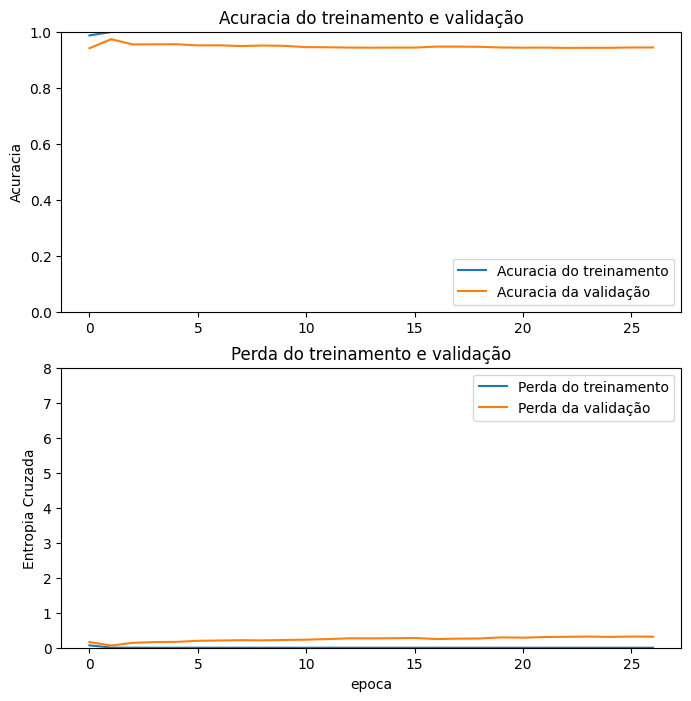

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Acuracia do treinamento')
plt.plot(val_acc, label='Acuracia da validação')
plt.legend(loc='lower right')
plt.ylabel('Acuracia')
plt.ylim([0,1])
plt.title('Acuracia do treinamento e validação')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Perda do treinamento')
plt.plot(val_loss, label='Perda da validação')
plt.legend(loc='upper right')
plt.ylabel('Entropia Cruzada')
plt.ylim([0,8])
plt.title('Perda do treinamento e validação')
plt.xlabel('epoca')
plt.show()

In [ ]:
    history = model.fit(batch_generator(df_treino_fold3, batch_size, _mode='train', label_set=rotulo, tam_img=tam_img),
                        steps_per_epoch=int(np.ceil(len(df_treino_fold3)/batch_size)),
                        epochs=100, verbose=1,
                        callbacks=callbacks_list,
                        validation_data=batch_generator(df_fold3, batch_size, _mode='val', label_set=rotulo, tam_img=tam_img),
                        validation_steps=int(np.ceil(len(df_fold3)/batch_size))
                      )

Epoch 1/100
373/373 [==============================] - ETA: 0s - loss: 0.0039 - acc: 0.9993 - auc: 0.9998 - precision: 0.9993 - recall: 0.9993
Epoch 1: val_loss improved from 0.06317 to 0.00001, saving model to model-001.model 
373/373 [==============================] - 33s 88ms/step - loss: 0.0039 - acc: 0.9993 - auc: 0.9998 - precision: 0.9993 - recall: 0.9993 - val_loss: 6.3348e-06 - val_acc: 1.0000 - val_auc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - lr: 4.0000e-04
Epoch 2/100
372/373 [============================>.] - ETA: 0s - loss: 1.4520e-05 - acc: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000
Epoch 2: val_loss did not improve from 0.00001
373/373 [==============================] - 33s 88ms/step - loss: 1.4503e-05 - acc: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 8.6824e-06 - val_acc: 1.0000 - val_auc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - lr: 4.0000e-04
Epoch 3/100
373/373 [==============================] - ETA

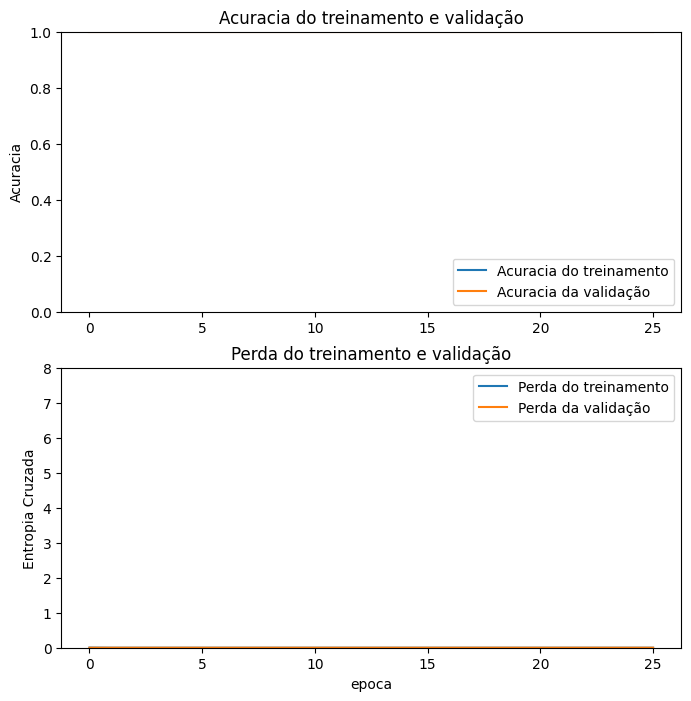

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Acuracia do treinamento')
plt.plot(val_acc, label='Acuracia da validação')
plt.legend(loc='lower right')
plt.ylabel('Acuracia')
plt.ylim([0,1])
plt.title('Acuracia do treinamento e validação')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Perda do treinamento')
plt.plot(val_loss, label='Perda da validação')
plt.legend(loc='upper right')
plt.ylabel('Entropia Cruzada')
plt.ylim([0,8])
plt.title('Perda do treinamento e validação')
plt.xlabel('epoca')
plt.show()

In [ ]:
    history = model.fit(batch_generator(df_treino_fold4, batch_size, _mode='train', label_set=rotulo, tam_img=tam_img),
                        steps_per_epoch=int(np.ceil(len(df_treino_fold4)/batch_size)),
                        epochs=100, verbose=1,
                        callbacks=callbacks_list,
                        validation_data=batch_generator(df_fold4, batch_size, _mode='val', label_set=rotulo, tam_img=tam_img),
                        validation_steps=int(np.ceil(len(df_fold4)/batch_size))
                      )

Epoch 1/100
370/370 [==============================] - ETA: 0s - loss: 1.7097e-04 - acc: 0.9999 - auc: 1.0000 - precision: 0.9999 - recall: 0.9999
Epoch 1: val_loss improved from 0.00001 to 0.00000, saving model to model-001.model 
370/370 [==============================] - 32s 87ms/step - loss: 1.7097e-04 - acc: 0.9999 - auc: 1.0000 - precision: 0.9999 - recall: 0.9999 - val_loss: 1.8032e-07 - val_acc: 1.0000 - val_auc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - lr: 8.0000e-05
Epoch 2/100
369/370 [============================>.] - ETA: 0s - loss: 1.4695e-06 - acc: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000
Epoch 2: val_loss improved from 0.00000 to 0.00000, saving model to model-002.model 
370/370 [==============================] - 34s 91ms/step - loss: 1.4669e-06 - acc: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.7760e-07 - val_acc: 1.0000 - val_auc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - lr: 8.0000e-05
Epoch 3/100


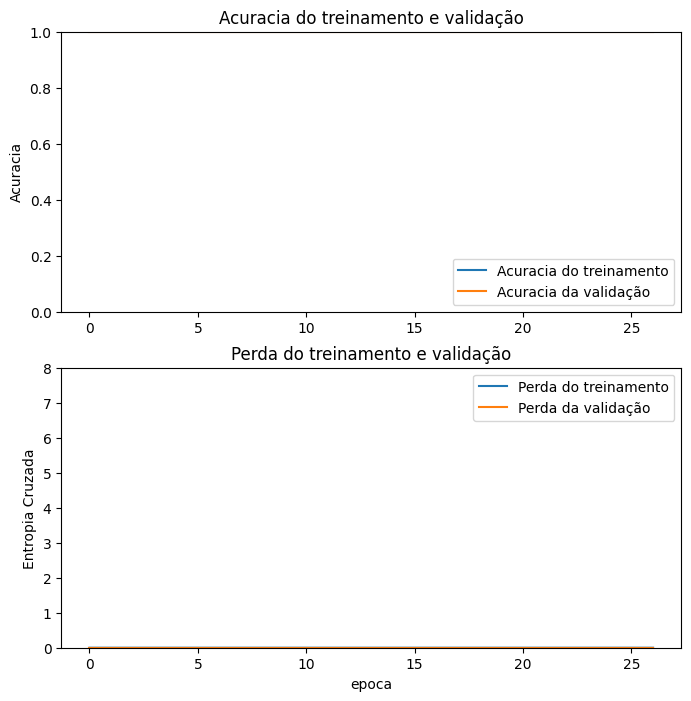

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Acuracia do treinamento')
plt.plot(val_acc, label='Acuracia da validação')
plt.legend(loc='lower right')
plt.ylabel('Acuracia')
plt.ylim([0,1])
plt.title('Acuracia do treinamento e validação')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Perda do treinamento')
plt.plot(val_loss, label='Perda da validação')
plt.legend(loc='upper right')
plt.ylabel('Entropia Cruzada')
plt.ylim([0,8])
plt.title('Perda do treinamento e validação')
plt.xlabel('epoca')
plt.show()

In [ ]:
model.evaluate(data_teste,target_teste)

83/83 [==============================] - 1s 13ms/step - loss: 14.4317 - acc: 0.3183 - auc: 0.5534 - precision: 0.3174 - recall: 0.3163


[14.431689262390137,
 0.31825095415115356,
 0.5533910393714905,
 0.3174360990524292,
 0.3163498044013977]

83/83 [==============================] - 1s 8ms/step


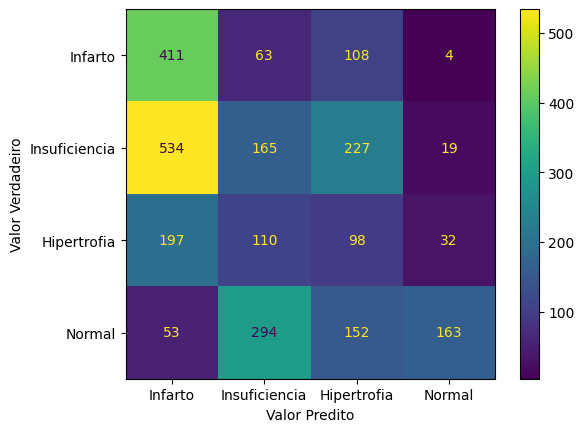

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(data_teste)

y_true = [np.argmax(y, axis=None, out=None) for y in target_teste]
y_true = np.array(y_true)

y_hat = [np.argmax(y, axis=None, out=None) for y in y_pred]
y_hat = np.array(y_hat)

confusion = confusion_matrix(y_true, y_hat)


ConfusionMatrixDisplay(confusion, display_labels=rotulo).plot()
plt.grid(False)
plt.xlabel("Valor Predito")
plt.ylabel("Valor Verdadeiro")
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_hat, digits=4))

              precision    recall  f1-score   support

           0     0.3439    0.7014    0.4615       586
           1     0.2611    0.1746    0.2093       945
           2     0.1675    0.2243    0.1918       437
           3     0.7477    0.2462    0.3705       662

    accuracy                         0.3183      2630
   macro avg     0.3801    0.3366    0.3083      2630
weighted avg     0.3865    0.3183    0.3031      2630

